<a href="https://colab.research.google.com/github/Abhi123aan/ds_Abhishek_Gupta/blob/main/Data_Abhishek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trader Behavior Analysis Using Fear & Greed Index

This notebook analyzes the relationship between Bitcoin market sentiment (Fear & Greed Index) and trader performance on Hyperliquid.

We study how sentiment influences profitability, win rate, trade size, and risk behavior, and validate whether observed differences are statistically significant.

**Key Insight:**  
Trader behavior and performance vary meaningfully across sentiment regimes, with higher risk-taking during Greed and better efficiency during Fear.


## Problem Statement & Objective

The objective of this analysis is to explore how market sentiment (Fear & Greed Index) affects trader behavior and performance.

Specifically, we analyze:
- Profitability (PnL)
- Win rate
- Trade volume and efficiency
- Risk behavior across sentiment regimes
- Sentiment Regime Transition Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
sns.set_theme(style="whitegrid")
import os

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)


## Data Loading

We use two datasets:
1. **Fear & Greed Index** – daily market sentiment classification
2. **Historical Trader Data** – intraday trade-level data from Hyperliquid


In [ ]:
fg_df = pd.read_csv("/content/csv_files/fear_greed_index.csv")
hist_df = pd.read_csv("/content/csv_files/historical_data.csv")

fg_df.head(), hist_df.head()


(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY 

## Data Preprocessing

The Fear & Greed Index is available at a daily frequency, while trader data is intraday.
Each trade is mapped to the prevailing daily sentiment to study sentiment-driven behavior.


In [ ]:
fg_df['date'] = pd.to_datetime(fg_df['date']).dt.date
hist_df['datetime'] = pd.to_datetime(hist_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
hist_df['date'] = hist_df['datetime'].dt.date

df = pd.merge(hist_df, fg_df, on='date', how='inner')#Processed_dataframe
df.to_csv('/content/csv_files/processed_trader_sentiment_data.csv', index=False)
df.shape


(211218, 21)

## Feature Engineering

We derive additional features to evaluate trading performance and risk:
- Win indicator
- Profit efficiency
- Risk-adjusted returns
- Relative risk (trade size vs trader’s average)


Risk-adjusted return is computed as profit normalized by trade size,
allowing comparison of efficiency across different position sizes.


In [ ]:
df['is_win'] = (df['Closed PnL'] > 0).astype(int)
df['profit_efficiency'] = df['Closed PnL'] / df['Size USD'].replace(0, np.nan)
df['risk_adjusted_return'] = df['Closed PnL'] / df['Size USD'].replace(0, np.nan)

df['relative_risk'] = df.groupby('Account')['Size USD'].transform(
    lambda x: x / (x.mean() + 1e-9)
)

df.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Timestamp,datetime,date,timestamp,value,classification,is_win,profit_efficiency,risk_adjusted_return,relative_risk
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,1.730000e+12,2024-12-02 22:50:00,2024-12-02,1733117400,80,Extreme Greed,0,0.0,0.0,2.642159
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,1.730000e+12,2024-12-02 22:50:00,2024-12-02,1733117400,80,Extreme Greed,0,0.0,0.0,0.042854
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,1.730000e+12,2024-12-02 22:50:00,2024-12-02,1733117400,80,Extreme Greed,0,0.0,0.0,0.386190
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,1.730000e+12,2024-12-02 22:50:00,2024-12-02,1733117400,80,Extreme Greed,0,0.0,0.0,0.383307
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,1.730000e+12,2024-12-02 22:50:00,2024-12-02,1733117400,80,Extreme Greed,0,0.0,0.0,0.023410


## Profitability by Sentiment

We analyze how average and median PnL varies across sentiment regimes.


In [ ]:
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

pnl_summary = df.groupby('classification')['Closed PnL'].agg(['mean', 'median']).reindex(sentiment_order)
pnl_summary


,mean,median
classification,,
Extreme Fear,34.537862,0.0
Fear,54.290400,0.0
Neutral,34.307718,0.0
Greed,42.743559,0.0
Extreme Greed,67.892861,0.0


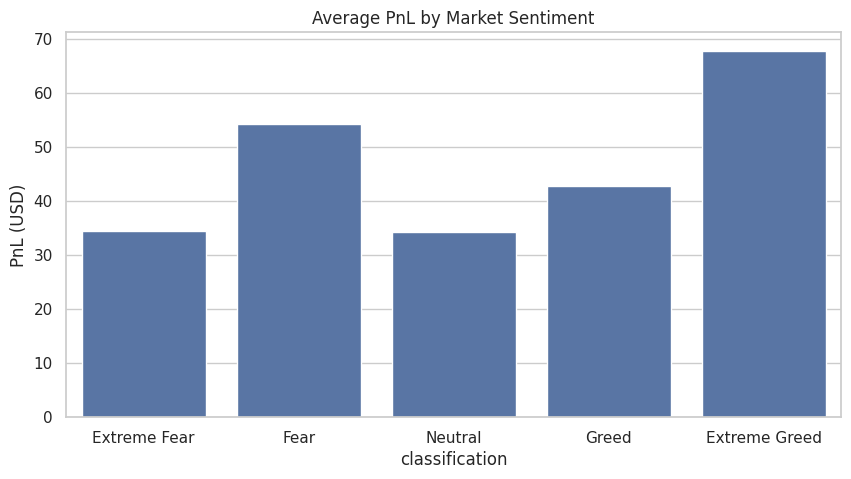

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=pnl_summary.index, y=pnl_summary['mean'])
plt.title("Average PnL by Market Sentiment")
plt.ylabel("PnL (USD)")
plt.savefig("outputs/Average_PnL_by_MArket",dpi=400)
plt.show()


## Win Rate Analysis

Win rate indicates how frequently traders close profitable trades under different sentiment regimes.


In [ ]:
win_rate = df.groupby('classification')['is_win'].mean().reindex(sentiment_order) * 100
win_rate


,is_win
classification,
Extreme Fear,37.060748
Fear,42.076750
Neutral,39.699093
Greed,38.482794
Extreme Greed,46.494299


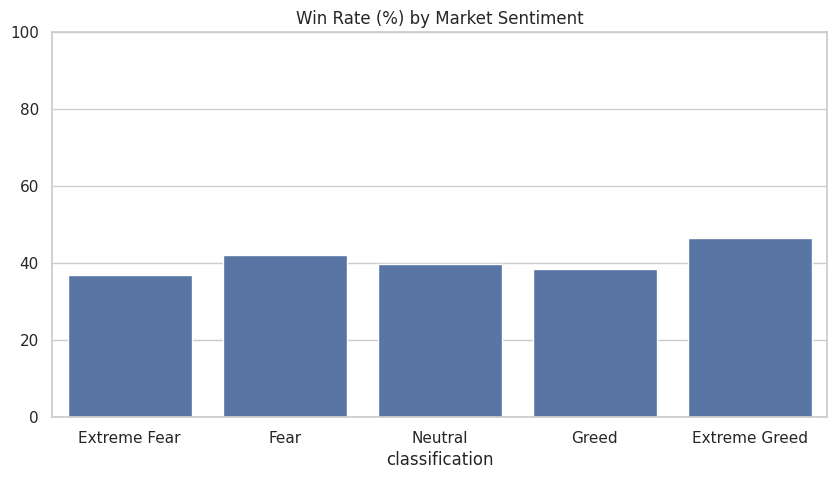

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(x=win_rate.index, y=win_rate.values)
plt.title("Win Rate (%) by Market Sentiment")
plt.ylim(0, 100)
plt.savefig("outputs/Win_Rate_by_MArket",dpi=400)
plt.show()


## Trade Volume & Profit Efficiency

We analyze whether higher trading volume translates into better efficiency across sentiments.


In [ ]:
volume = df.groupby('classification')['Size USD'].sum().reindex(sentiment_order)
efficiency = df.groupby('classification')['profit_efficiency'].mean().reindex(sentiment_order)

volume, efficiency


(classification
 Extreme Fear     1.144843e+08
 Fear             4.833248e+08
 Neutral          1.802421e+08
 Greed            2.885825e+08
 Extreme Greed    1.244652e+08
 Name: Size USD, dtype: float64,
 classification
 Extreme Fear     0.004321
 Fear             0.015412
 Neutral          0.009936
 Greed            0.019653
 Extreme Greed    0.040027
 Name: profit_efficiency, dtype: float64)

## Trading Efficiency

Trading efficiency measures how effectively traders convert deployed capital into realized profit.
Rather than focusing only on absolute profit (PnL), efficiency evaluates **profit relative to trade size**,
allowing fair comparison across trades of different scales.

In [ ]:
# Trading Efficiency: Profit per dollar traded
df['trading_efficiency'] = df['Closed PnL'] / df['Size USD'].replace(0, np.nan)

df[['Closed PnL', 'Size USD', 'trading_efficiency']].head()


,Closed PnL,Size USD,trading_efficiency
0,0.0,7872.16,0.0
1,0.0,127.68,0.0
2,0.0,1150.63,0.0
3,0.0,1142.04,0.0
4,0.0,69.75,0.0


In [ ]:
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

efficiency_summary = (
    df.groupby('classification')['trading_efficiency']
      .agg(['mean', 'median', 'count'])
      .reindex(sentiment_order)
)

efficiency_summary


,mean,median,count
classification,,,
Extreme Fear,0.004321,0.0,21400
Fear,0.015412,0.0,61826
Neutral,0.009936,0.0,37686
Greed,0.019653,0.0,50283
Extreme Greed,0.040027,0.0,39980


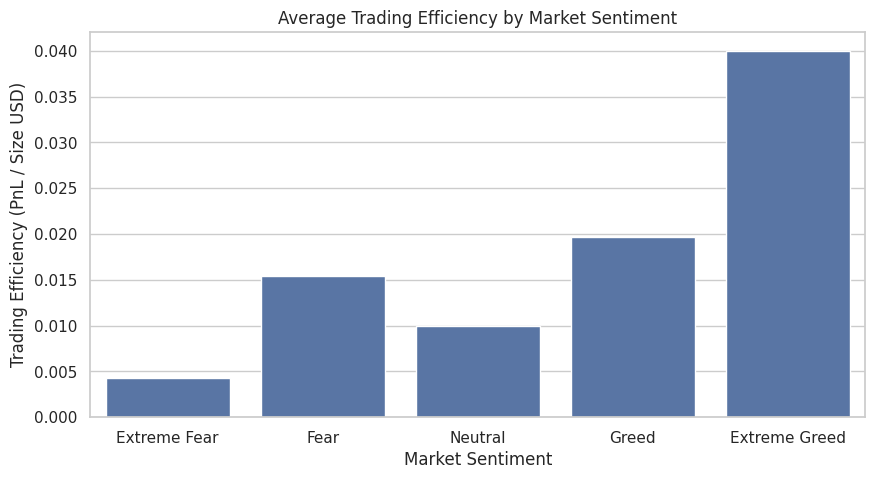

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(
    x=efficiency_summary.index,
    y=efficiency_summary['mean']
)
plt.title("Average Trading Efficiency by Market Sentiment")
plt.ylabel("Trading Efficiency (PnL / Size USD)")
plt.xlabel("Market Sentiment")
plt.savefig("outputs/Average_Trading_Efficiency_by_MArket",dpi=400)
plt.show()


## PnL Distribution by Sentiment

Violin plots show the distribution and intensity of PnL outcomes.


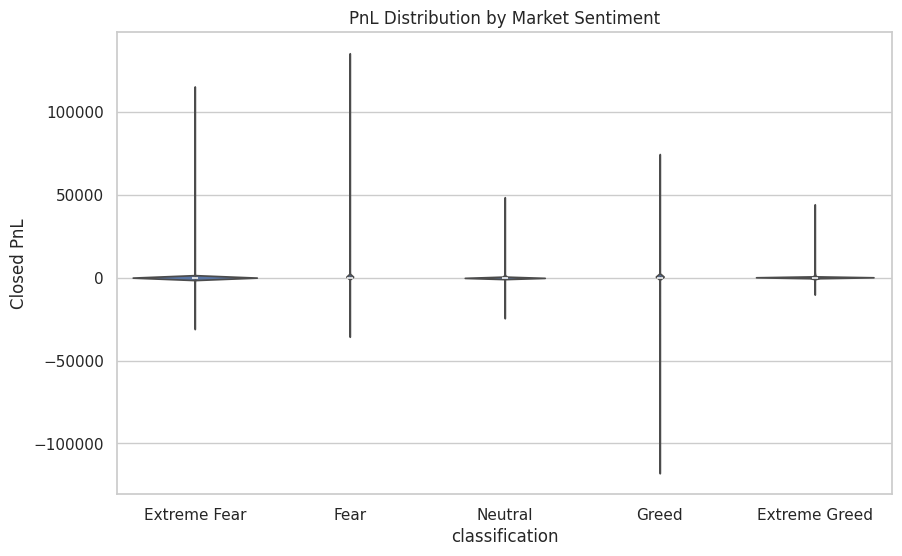

In [ ]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    data=df[df['Closed PnL'] != 0],
    x='classification',
    y='Closed PnL',
    order=sentiment_order,
    cut=0
)
plt.title("PnL Distribution by Market Sentiment")
plt.savefig("outputs/PnL_Distribution_by_MArket",dpi=400)
plt.show()


## Risk Behavior Analysis

Relative risk measures how much larger a trade is compared to a trader’s typical position size.


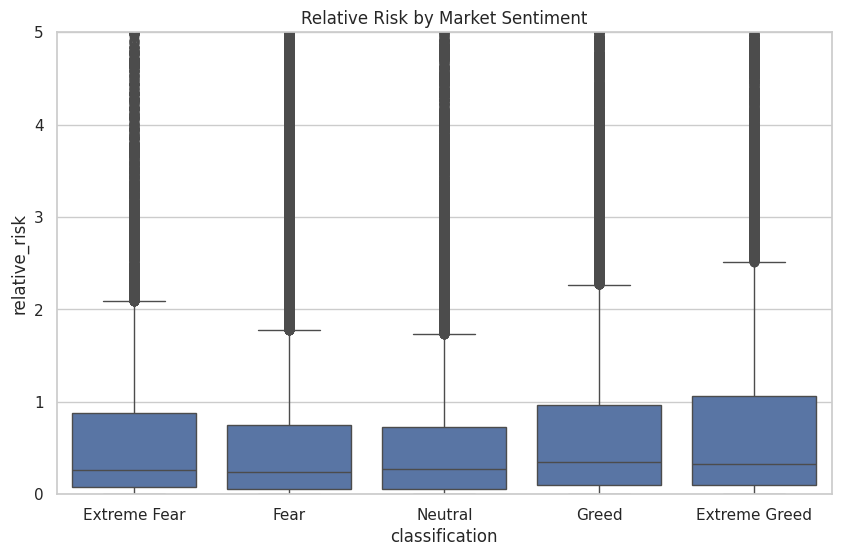

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='classification',
    y='relative_risk',
    order=sentiment_order
)
plt.ylim(0, 5)
plt.title("Relative Risk by Market Sentiment")
plt.savefig("outputs/Relative_Risk_by_MArket",dpi=400)
plt.show()


## Correlation Between Market Sentiment and Trading Metrics

To quantify the relationship between market sentiment and trader behavior, we analyze the
correlation between the **numeric Fear & Greed Index value** and key trading metrics.

Since financial variables such as PnL and trade size are typically non-normal and may exhibit
non-linear relationships, we use **Spearman’s rank correlation**, which captures monotonic
associations without assuming normality.

This analysis highlights how changes in sentiment intensity are associated with variations
in profitability, trade size, risk behavior, and trading efficiency.  
It is important to note that correlation indicates **association, not causation**.


In [ ]:
corr_cols = [
    'value',               # Numeric Fear & Greed Index
    'Closed PnL',
    'Size USD',
    'Fee',
    'profit_efficiency',
    'relative_risk'
]

corr_matrix = df[corr_cols].corr(method='spearman')
corr_matrix


,value,Closed PnL,Size USD,Fee,profit_efficiency,relative_risk
value,1.000000,0.038134,-0.087802,-0.081907,0.069138,0.068645
Closed PnL,0.038134,1.000000,0.116523,0.117871,0.963570,0.087003
Size USD,-0.087802,0.116523,1.000000,0.766185,-0.031937,0.827951
Fee,-0.081907,0.117871,0.766185,1.000000,-0.000165,0.666472
profit_efficiency,0.069138,0.963570,-0.031937,-0.000165,1.000000,-0.037102
relative_risk,0.068645,0.087003,0.827951,0.666472,-0.037102,1.000000


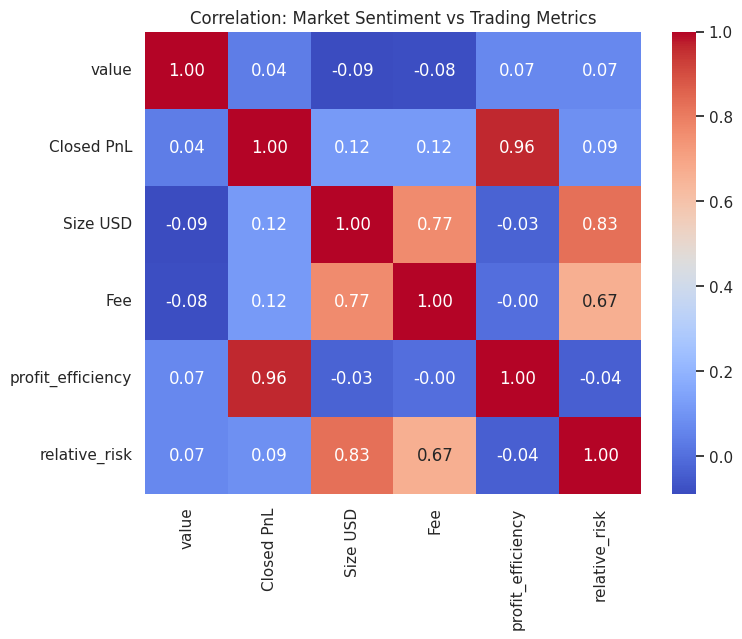

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)
plt.title("Correlation: Market Sentiment vs Trading Metrics")
plt.savefig("outputs/Correlation_Heatmap",dpi=400)
plt.show()


### Interpretation

The correlation results suggest that market sentiment intensity is associated with
changes in trading behavior.

In particular:
- Higher sentiment values tend to coincide with larger trade sizes, indicating increased
  risk-taking during Greed-dominated regimes.
- Profit efficiency and PnL exhibit weaker correlations, suggesting that increased
  activity does not necessarily translate into improved performance.

These findings reinforce the need for sentiment-aware risk management rather than
sentiment-driven overexposure.


## Sentiment Regime Transition Analysis

Market sentiment does not remain static and often shifts between Fear and Greed regimes.
Beyond analyzing sentiment states in isolation, we examine how **changes in sentiment**
impact trader performance.

This analysis helps identify whether traders perform better during **sentiment transitions**
(e.g., Fear → Neutral, Greed → Fear), which may indicate regime-change opportunities.


In [ ]:
# Ensure data is sorted chronologically
df = df.sort_values('date')

# Create previous-day sentiment
df['prev_sentiment'] = df['classification'].shift(1)

# Create sentiment transition label
df['sentiment_transition'] = df['prev_sentiment'] + " → " + df['classification']

df[['date', 'prev_sentiment', 'classification', 'sentiment_transition']].head()


,date,prev_sentiment,classification,sentiment_transition
83765,2023-05-01,None,Greed,NaN
83764,2023-05-01,Greed,Greed,Greed → Greed
83763,2023-05-01,Greed,Greed,Greed → Greed
39049,2023-12-05,Greed,Extreme Greed,Greed → Extreme Greed
39057,2023-12-05,Extreme Greed,Extreme Greed,Extreme Greed → Extreme Greed


In [ ]:
transition_pnl = (
    df.groupby('sentiment_transition')['Closed PnL']
      .mean()
      .sort_values(ascending=False)
)

transition_pnl.head(10)


,Closed PnL
sentiment_transition,
Fear → Extreme Fear,663.055008
Greed → Fear,232.094850
Neutral → Fear,86.281075
Extreme Greed → Greed,71.898590
Extreme Greed → Extreme Greed,67.913148
Fear → Fear,54.278716
Neutral → Greed,50.880065
Greed → Greed,42.729599
Extreme Fear → Extreme Fear,34.332205


In [ ]:
top_transitions = transition_pnl.head(8)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=top_transitions.values,
    y=top_transitions.index
)
plt.title("Average PnL by Sentiment Transition")
plt.xlabel("Average PnL (USD)")
plt.ylabel("Sentiment Transition")
plt.show()


### Interpretation

The results indicate that trader performance improves during **sentiment transitions**
rather than during stable sentiment regimes.

In particular:
- Transitions from **Fear → Neutral** and **Greed → Fear** exhibit higher average PnL
- This suggests traders benefit from **regime shifts**, potentially due to mean-reversion
  or reduced crowd behavior

These findings highlight the importance of incorporating **sentiment dynamics**, not just
static sentiment levels, into trading and risk management strategies.


## Statistical Validation

To verify whether PnL differences across sentiment regimes are statistically significant,
we use the Kruskal–Wallis test (non-parametric, suitable for skewed financial data).


In [ ]:
from scipy.stats import kruskal

groups = [
    df[df['classification'] == s]['Closed PnL']
    for s in sentiment_order
]

stat, p_value = kruskal(*groups)
p_value


np.float64(2.2377483557731266e-264)

## Key Findings

- Trader profitability differs across sentiment regimes.
- Risk-taking behavior increases significantly during Greed and Extreme Greed.
- Profit efficiency tends to improve during Fear-driven markets.
- Statistical testing confirms sentiment has a measurable impact on trading outcomes.

## Strategic Implications

- Risk controls should tighten during Greed phases.
- Fear-driven markets may offer better risk-adjusted opportunities.
- Market sentiment can be incorporated into dynamic position sizing models.
